In [1]:
import dlib
import skvideo.io as skv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from tqdm import tqdm
import random
import time

# prepare_image

In [50]:
IMAGE_SIZE = (128, 64)

face_detector = dlib.get_frontal_face_detector()
lip_detector = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

def video_to_lib_paper(vid_path):
    try:
        MOUTH_WIDTH = 128
        MOUTH_HEIGHT = 64
        HORIZONTAL_PAD = 0.19
        vid = skv.vread(vid_path)
        out = np.zeros((75,64,128,3))
        for i in range(vid.shape[0]):
            tmp_image = vid[i,:,:,:]

            # check if there are face in image or not
            rec_list, _, _  = face_detector.run(tmp_image,1)

            if len(rec_list) > 1:
                print("too many face")
                return -1
            elif len(rec_list) == 0:
                print("no face")
                return -1

            landmarks = lip_detector(tmp_image,rec_list[0]).parts()

            lip_point = np.array([[p.x,p.y] for p in landmarks[48:69]])
    #         print(lip_point)
    #         print(lip_point[:, -2:])
            mouth_centroid = np.mean(lip_point[:, -2:], axis=0)

            mouth_left = np.min(lip_point[:, :-1]) * (1.0 - HORIZONTAL_PAD)
            mouth_right = np.max(lip_point[:, :-1]) * (1.0 + HORIZONTAL_PAD)

            normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)
            new_img_shape = (int(tmp_image.shape[0] * normalize_ratio), int(tmp_image.shape[1] * normalize_ratio))
            tmp_image = cv2.resize(tmp_image,(new_img_shape[1],new_img_shape[0]))

            mouth_centroid_norm = mouth_centroid * normalize_ratio
            lip_point_norm = lip_point * normalize_ratio

            lip_point_y = lip_point_norm[:,0] / new_img_shape[0]
            lip_point_y = lip_point_y.flatten()
            assert np.sum(lip_point_y > 1) == 0

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = tmp_image[mouth_t:mouth_b, mouth_l:mouth_r]

            out[i,:,:,:] = mouth_crop_image

        # normalize
        out = out/255

        # create folder image
        save_path = "./data_prepare_new/" + vid_path[7:-4]
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # export image
        for i in range(out.shape[0]):
            plt.imsave(save_path+"/"+str(i)+".jpg",out[i])

        # create folder landmarks
        save_path = "./landmarks/" + vid_path[7:-4]
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # export landmarks
        np.save(save_path,lip_point_y)
    except:
        print(vid_path)
        return -1

In [76]:
def video_to_landmark(vid_path):
    try:
        MOUTH_WIDTH = 128
        MOUTH_HEIGHT = 64
        HORIZONTAL_PAD = 0.19
        vid = skv.vread(vid_path)
        out = np.zeros((75,40))
        
        # create folder image
#         save_path = "./data_prepare_new/" + vid_path[7:-4]
#         if not os.path.exists(save_path):
#             return -1
            
        for i in range(vid.shape[0]):
            tmp_image = vid[i,:,:,:]

            # check if there are face in image or not
            rec_list, _, _  = face_detector.run(tmp_image,1)

            if len(rec_list) > 1:
                print("too many face")
                return -1
            elif len(rec_list) == 0:
                print("no face")
                return -1
            landmarks = lip_detector(tmp_image,rec_list[0]).parts()

            lip_point = np.array([[p.x,p.y] for p in landmarks[48:69]])
            
            mouth_centroid = np.mean(lip_point[:, -2:], axis=0)

            mouth_left = np.min(lip_point[:, :-1]) * (1.0 - HORIZONTAL_PAD)
            mouth_right = np.max(lip_point[:, :-1]) * (1.0 + HORIZONTAL_PAD)

            normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)
            new_img_shape = (int(tmp_image.shape[0] * normalize_ratio), int(tmp_image.shape[1] * normalize_ratio))

            lip_point_norm = lip_point * normalize_ratio

#             lip_point_y = lip_point_norm[:,0] / new_img_shape[0]
#             lip_point_y = lip_point_y.flatten()
            
#             lip_point_x = lip_point_norm[:,1] / new_img_shape[1]
#             lip_point_x = lip_point_x.flatten()

            lip_point_norm[:,0] = lip_point_norm[:,0] / new_img_shape[0]
            lip_point_norm[:,1] = lip_point_norm[:,1] / new_img_shape[1]
            lip_point_norm = lip_point_norm.flatten()
            
            
            assert np.sum(lip_point_norm > 1) == 0

            out[i,:] = lip_point_norm
            

        # create folder landmarks
        save_path = "./landmark_new/" + vid_path[7:-4]
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # export landmarks
        np.save(save_path,out)
        return out
    except:
        print(vid_path)
        return -1

In [77]:
train_p = ["s"+str(i) for i in range(1,35) if i != 1 and i != 20 and i != 2 and i != 22 and i != 21]
val_p = ["s1","s20"]
test_p = ["s2","s22"]

In [78]:
def prepare_list_path(p):
    vid = []
    label = []
    for people in tqdm(p,total=len(p)):
        vid_path = "./data/"+people+"/"
        for vid_name in os.listdir(vid_path):
            align_name = vid_name[:6] + ".align"
            vid.append(vid_path + vid_name)
            label.append("./data/align/" + align_name)
            
    return vid, label

In [79]:
train_vid, train_label = prepare_list_path(train_p)

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 517.86it/s]


In [80]:
val_vid, val_label = prepare_list_path(val_p)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.98it/s]


In [81]:
test_vid, test_label = prepare_list_path(test_p)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 666.40it/s]


In [82]:
"./data_prepare/" + train_vid[0][7:-4]

'./data_prepare/s3/bbaf1s'

# visualize landmark

In [84]:
lip_visual = video_to_landmark(train_vid[0])

In [89]:
import matplotlib.pyplot as plt

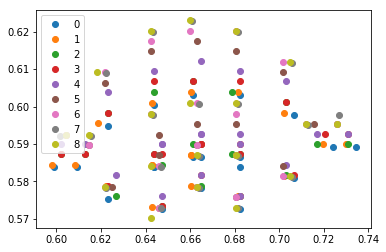

In [94]:
plt.plot(lip_visual[0].reshape((20,2))[:,0], lip_visual[0].reshape((20,2))[:,1], 'o', label='0')
plt.plot(lip_visual[1].reshape((20,2))[:,0], lip_visual[1].reshape((20,2))[:,1], 'o', label='1')
plt.plot(lip_visual[2].reshape((20,2))[:,0], lip_visual[2].reshape((20,2))[:,1], 'o', label='2')
plt.plot(lip_visual[3].reshape((20,2))[:,0], lip_visual[3].reshape((20,2))[:,1], 'o', label='3')
plt.plot(lip_visual[4].reshape((20,2))[:,0], lip_visual[4].reshape((20,2))[:,1], 'o', label='4')
plt.plot(lip_visual[5].reshape((20,2))[:,0], lip_visual[5].reshape((20,2))[:,1], 'o', label='5')
plt.plot(lip_visual[6].reshape((20,2))[:,0], lip_visual[6].reshape((20,2))[:,1], 'o', label='6')
plt.plot(lip_visual[7].reshape((20,2))[:,0], lip_visual[7].reshape((20,2))[:,1], 'o', label='7')
plt.plot(lip_visual[8].reshape((20,2))[:,0], lip_visual[8].reshape((20,2))[:,1], 'o', label='8')
plt.legend()

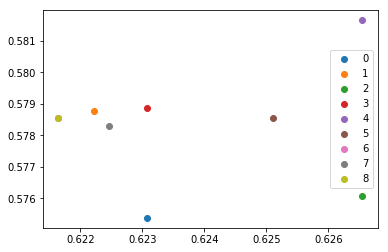

In [96]:
point = 1
plt.plot(lip_visual[0].reshape((20,2))[point,0], lip_visual[0].reshape((20,2))[point,1], 'o', label='0')
plt.plot(lip_visual[1].reshape((20,2))[point,0], lip_visual[1].reshape((20,2))[point,1], 'o', label='1')
plt.plot(lip_visual[2].reshape((20,2))[point,0], lip_visual[2].reshape((20,2))[point,1], 'o', label='2')
plt.plot(lip_visual[3].reshape((20,2))[point,0], lip_visual[3].reshape((20,2))[point,1], 'o', label='3')
plt.plot(lip_visual[4].reshape((20,2))[point,0], lip_visual[4].reshape((20,2))[point,1], 'o', label='4')
plt.plot(lip_visual[5].reshape((20,2))[point,0], lip_visual[5].reshape((20,2))[point,1], 'o', label='5')
plt.plot(lip_visual[6].reshape((20,2))[point,0], lip_visual[6].reshape((20,2))[point,1], 'o', label='6')
plt.plot(lip_visual[7].reshape((20,2))[point,0], lip_visual[7].reshape((20,2))[point,1], 'o', label='7')
plt.plot(lip_visual[8].reshape((20,2))[point,0], lip_visual[8].reshape((20,2))[point,1], 'o', label='8')
plt.legend()

# export

In [97]:
for a in tqdm(train_vid,total=len(train_vid)):
    video_to_landmark(a)
for a in tqdm(val_vid,total=len(val_vid)):
    video_to_landmark(a)
for a in tqdm(test_vid,total=len(test_vid)):
    video_to_landmark(a)

  0%|▏                                                                           | 87/29029 [08:55<51:36:10,  6.42s/it]

no face


  0%|▎                                                                          | 104/29029 [10:37<49:02:23,  6.10s/it]

no face


  0%|▎                                                                          | 131/29029 [13:19<47:11:20,  5.88s/it]

no face


  1%|▋                                                                          | 277/29029 [28:13<48:13:57,  6.04s/it]

no face


  1%|▋                                                                          | 279/29029 [28:19<37:47:58,  4.73s/it]

no face


  1%|▊                                                                          | 333/29029 [33:51<50:30:35,  6.34s/it]

no face


  1%|▉                                                                          | 387/29029 [38:56<46:23:32,  5.83s/it]

no face


  2%|█▍                                                                         | 534/29029 [52:07<42:27:26,  5.36s/it]

no face


  2%|█▌                                                                         | 615/29029 [59:16<43:37:53,  5.53s/it]

no face


  2%|█▋                                                                       | 676/29029 [1:04:38<42:04:48,  5.34s/it]

no face


  3%|██▍                                                                      | 980/29029 [1:31:56<41:04:06,  5.27s/it]

no face


  3%|██▍                                                                     | 1000/29029 [1:33:40<40:58:37,  5.26s/it]

./data/s3/Thumbs.db


  5%|███▎                                                                    | 1316/29029 [2:02:04<44:22:01,  5.76s/it]

too many face


  5%|███▎                                                                    | 1352/29029 [2:05:13<40:30:40,  5.27s/it]

too many face


  5%|███▋                                                                    | 1472/29029 [2:15:52<40:13:02,  5.25s/it]

no face


  6%|████                                                                    | 1631/29029 [2:30:10<40:54:04,  5.37s/it]

too many face


  7%|████▉                                                                   | 2001/29029 [3:03:18<40:16:22,  5.36s/it]

./data/s4/Thumbs.db


  8%|█████▌                                                                  | 2262/29029 [3:26:31<39:23:35,  5.30s/it]

no face


 10%|███████▍                                                                | 3002/29029 [4:32:39<37:31:41,  5.19s/it]

./data/s5/Thumbs.db


 11%|███████▋                                                                | 3086/29029 [4:40:10<38:31:38,  5.35s/it]

no face


 11%|███████▋                                                                | 3124/29029 [4:43:27<38:02:37,  5.29s/it]

no face


 12%|████████▌                                                               | 3461/29029 [5:13:31<37:37:04,  5.30s/it]

no face


 13%|█████████▏                                                              | 3689/29029 [5:33:44<36:58:05,  5.25s/it]

no face


 13%|█████████▍                                                              | 3788/29029 [5:42:22<36:56:47,  5.27s/it]

no face


 13%|█████████▍                                                              | 3809/29029 [5:44:13<37:23:55,  5.34s/it]

no face


 13%|█████████▋                                                              | 3884/29029 [5:50:49<37:18:38,  5.34s/it]

no face


 13%|█████████▋                                                              | 3912/29029 [5:53:15<37:12:24,  5.33s/it]

no face


 14%|█████████▊                                                              | 3967/29029 [5:58:02<36:34:01,  5.25s/it]

too many face


 14%|█████████▉                                                              | 3988/29029 [5:59:52<37:10:10,  5.34s/it]

no face


 14%|█████████▉                                                              | 4003/29029 [6:01:07<36:47:28,  5.29s/it]

./data/s6/Thumbs.db


 14%|██████████                                                              | 4044/29029 [6:04:45<37:05:58,  5.35s/it]

no face


 14%|██████████                                                              | 4045/29029 [6:04:45<26:41:05,  3.85s/it]

no face


 14%|██████████                                                              | 4077/29029 [6:07:33<37:37:18,  5.43s/it]

no face


 15%|██████████▌                                                             | 4244/29029 [6:22:22<36:18:58,  5.27s/it]

no face


 15%|██████████▊                                                             | 4365/29029 [6:33:00<38:43:53,  5.65s/it]

no face


 15%|██████████▉                                                             | 4420/29029 [6:37:45<36:05:55,  5.28s/it]

no face


 15%|███████████                                                             | 4440/29029 [6:39:26<35:40:23,  5.22s/it]

no face


 15%|███████████▏                                                            | 4492/29029 [6:43:54<35:49:15,  5.26s/it]

no face


 16%|███████████▋                                                            | 4726/29029 [7:04:40<36:07:41,  5.35s/it]

no face


 16%|███████████▊                                                            | 4767/29029 [7:08:11<35:58:34,  5.34s/it]

no face


 17%|████████████                                                            | 4853/29029 [7:15:41<35:50:50,  5.34s/it]

no face


 17%|████████████▍                                                           | 5004/29029 [7:29:02<35:49:48,  5.37s/it]

./data/s7/Thumbs.db


 17%|████████████▌                                                           | 5071/29029 [7:34:29<36:07:28,  5.43s/it]

too many face


 17%|████████████▌                                                           | 5073/29029 [7:34:39<34:57:48,  5.25s/it]

too many face


 17%|████████████▌                                                           | 5077/29029 [7:34:55<28:20:05,  4.26s/it]

too many face


 18%|████████████▋                                                           | 5114/29029 [7:37:56<24:53:51,  3.75s/it]

too many face


 18%|████████████▋                                                           | 5122/29029 [7:38:30<25:27:05,  3.83s/it]

too many face


 18%|████████████▊                                                           | 5152/29029 [7:40:53<29:00:45,  4.37s/it]

too many face


 18%|████████████▉                                                           | 5205/29029 [7:45:06<31:52:00,  4.82s/it]

too many face


 18%|█████████████▏                                                          | 5338/29029 [7:55:44<34:41:22,  5.27s/it]

too many face


 18%|█████████████▎                                                          | 5364/29029 [7:57:49<34:14:36,  5.21s/it]

too many face


 19%|█████████████▌                                                          | 5472/29029 [8:06:33<30:27:47,  4.66s/it]

too many face


 19%|█████████████▊                                                          | 5545/29029 [8:12:33<28:24:25,  4.35s/it]

too many face


 19%|█████████████▊                                                          | 5559/29029 [8:13:43<35:15:33,  5.41s/it]

too many face


 20%|██████████████▏                                                         | 5742/29029 [8:28:16<31:18:20,  4.84s/it]

too many face


 20%|██████████████▋                                                         | 5931/29029 [8:43:43<32:32:14,  5.07s/it]

too many face


 21%|██████████████▊                                                         | 5958/29029 [8:46:07<35:13:42,  5.50s/it]

too many face


 21%|██████████████▉                                                         | 6005/29029 [8:49:49<29:00:21,  4.54s/it]

./data/s8/Thumbs.db


 21%|███████████████▎                                                        | 6188/29029 [9:06:20<35:05:28,  5.53s/it]

no face


 24%|█████████████████▏                                                     | 7006/29029 [10:19:55<32:28:27,  5.31s/it]

./data/s9/Thumbs.db


 28%|███████████████████▌                                                   | 8007/29029 [11:50:31<31:56:41,  5.47s/it]

./data/s10/Thumbs.db


 30%|█████████████████████                                                  | 8602/29029 [12:45:09<31:31:33,  5.56s/it]

no face


 31%|██████████████████████                                                 | 9008/29029 [13:22:24<30:58:07,  5.57s/it]

./data/s11/Thumbs.db


 34%|████████████████████████▏                                             | 10009/29029 [14:55:22<29:22:17,  5.56s/it]

./data/s12/Thumbs.db


 37%|█████████████████████████▊                                            | 10726/29029 [16:02:35<28:55:07,  5.69s/it]

too many face


 38%|██████████████████████████▌                                           | 11010/29029 [16:29:13<28:24:03,  5.67s/it]

./data/s13/Thumbs.db


 41%|████████████████████████████▉                                         | 12011/29029 [18:03:27<26:22:25,  5.58s/it]

./data/s14/Thumbs.db


 41%|████████████████████████████▉                                         | 12015/29029 [18:03:45<23:56:03,  5.06s/it]

too many face


 42%|█████████████████████████████▏                                        | 12080/29029 [18:09:53<26:46:56,  5.69s/it]

no face


 42%|█████████████████████████████▏                                        | 12109/29029 [18:12:31<26:29:29,  5.64s/it]

no face


 42%|█████████████████████████████▏                                        | 12113/29029 [18:12:49<24:16:10,  5.16s/it]

too many face


 42%|█████████████████████████████▏                                        | 12114/29029 [18:12:51<19:56:02,  4.24s/it]

too many face


 42%|█████████████████████████████▍                                        | 12184/29029 [18:19:27<26:54:52,  5.75s/it]

no face


 42%|█████████████████████████████▍                                        | 12200/29029 [18:20:52<26:15:36,  5.62s/it]

no face


 42%|█████████████████████████████▋                                        | 12299/29029 [18:30:04<27:23:44,  5.90s/it]

no face


 42%|█████████████████████████████▋                                        | 12307/29029 [18:30:44<25:33:35,  5.50s/it]

no face


 43%|█████████████████████████████▊                                        | 12377/29029 [18:37:11<25:51:21,  5.59s/it]

no face


 43%|█████████████████████████████▉                                        | 12398/29029 [18:39:02<25:54:33,  5.61s/it]

no face


 43%|██████████████████████████████                                        | 12486/29029 [18:47:08<25:41:47,  5.59s/it]

no face


 43%|██████████████████████████████▏                                       | 12537/29029 [18:51:46<25:13:23,  5.51s/it]

no face


 43%|██████████████████████████████▎                                       | 12595/29029 [18:57:08<25:45:42,  5.64s/it]

no face


 44%|██████████████████████████████▌                                       | 12668/29029 [19:03:56<26:49:52,  5.90s/it]

too many face


 44%|██████████████████████████████▌                                       | 12681/29029 [19:05:05<25:29:22,  5.61s/it]

no face


 44%|██████████████████████████████▌                                       | 12682/29029 [19:05:06<18:19:01,  4.03s/it]

too many face


 44%|██████████████████████████████▋                                       | 12739/29029 [19:10:27<25:23:19,  5.61s/it]

no face


 44%|██████████████████████████████▊                                       | 12772/29029 [19:13:26<25:10:59,  5.58s/it]

no face


 44%|██████████████████████████████▊                                       | 12774/29029 [19:13:32<20:23:15,  4.52s/it]

no face


 44%|██████████████████████████████▉                                       | 12813/29029 [19:17:06<25:20:52,  5.63s/it]

no face


 44%|██████████████████████████████▉                                       | 12816/29029 [19:17:17<21:54:25,  4.86s/it]

too many face


 44%|███████████████████████████████                                       | 12881/29029 [19:23:22<24:54:54,  5.55s/it]

no face


 45%|███████████████████████████████▎                                      | 12972/29029 [19:31:49<25:01:01,  5.61s/it]

no face


 45%|███████████████████████████████▍                                      | 13012/29029 [19:35:28<24:27:39,  5.50s/it]

./data/s15/Thumbs.db


 45%|███████████████████████████████▍                                      | 13048/29029 [19:38:43<24:56:45,  5.62s/it]

too many face


 46%|███████████████████████████████▉                                      | 13246/29029 [19:57:13<24:50:54,  5.67s/it]

too many face


 46%|████████████████████████████████                                      | 13320/29029 [20:04:04<24:07:46,  5.53s/it]

too many face


 46%|████████████████████████████████▎                                     | 13382/29029 [20:09:47<24:16:45,  5.59s/it]

too many face


 46%|████████████████████████████████▎                                     | 13384/29029 [20:09:55<21:18:48,  4.90s/it]

too many face


 46%|████████████████████████████████▎                                     | 13392/29029 [20:10:40<24:15:07,  5.58s/it]

too many face


 46%|████████████████████████████████▎                                     | 13423/29029 [20:13:30<23:53:03,  5.51s/it]

too many face


 46%|████████████████████████████████▍                                     | 13429/29029 [20:13:58<22:35:34,  5.21s/it]

too many face


 46%|████████████████████████████████▌                                     | 13496/29029 [20:20:05<24:04:26,  5.58s/it]

too many face


 47%|████████████████████████████████▌                                     | 13526/29029 [20:22:47<23:51:17,  5.54s/it]

too many face


 47%|████████████████████████████████▌                                     | 13529/29029 [20:23:00<21:36:34,  5.02s/it]

too many face


 47%|████████████████████████████████▊                                     | 13591/29029 [20:28:46<23:05:40,  5.39s/it]

too many face


 47%|████████████████████████████████▊                                     | 13593/29029 [20:28:55<21:04:59,  4.92s/it]

too many face


 47%|████████████████████████████████▉                                     | 13637/29029 [20:32:57<23:36:27,  5.52s/it]

too many face


 48%|█████████████████████████████████▌                                    | 13939/29029 [21:00:49<22:48:28,  5.44s/it]

too many face


 48%|█████████████████████████████████▊                                    | 14013/29029 [21:07:31<23:11:28,  5.56s/it]

./data/s16/Thumbs.db


 49%|██████████████████████████████████▍                                   | 14297/29029 [21:33:10<21:55:06,  5.36s/it]

no face


 52%|████████████████████████████████████▏                                 | 15014/29029 [22:42:08<26:37:03,  6.84s/it]

./data/s17/Thumbs.db


 55%|██████████████████████████████████████▌                               | 16015/29029 [24:16:32<19:34:27,  5.41s/it]

./data/s18/Thumbs.db


 59%|█████████████████████████████████████████                             | 17016/29029 [25:47:23<18:39:46,  5.59s/it]

./data/s19/Thumbs.db


 62%|███████████████████████████████████████████▍                          | 18017/29029 [27:17:58<16:40:13,  5.45s/it]

./data/s23/Thumbs.db


 66%|█████████████████████████████████████████████▊                        | 19018/29029 [28:48:16<15:00:32,  5.40s/it]

./data/s24/Thumbs.db


 69%|████████████████████████████████████████████████▎                     | 20019/29029 [30:18:28<13:14:38,  5.29s/it]

./data/s25/Thumbs.db


 72%|██████████████████████████████████████████████████▋                   | 21020/29029 [31:54:52<12:03:12,  5.42s/it]

./data/s26/Thumbs.db


 73%|███████████████████████████████████████████████████▏                  | 21229/29029 [32:13:41<11:50:01,  5.46s/it]

too many face


 75%|████████████████████████████████████████████████████▏                 | 21632/29029 [32:49:52<11:12:27,  5.45s/it]

too many face


 76%|█████████████████████████████████████████████████████                 | 22021/29029 [33:25:13<10:36:07,  5.45s/it]

./data/s27/Thumbs.db


 77%|██████████████████████████████████████████████████████▋                | 22345/29029 [33:54:24<9:58:18,  5.37s/it]

./data/s28/lgadza.mpg


 77%|██████████████████████████████████████████████████████▊                | 22427/29029 [34:01:42<9:44:38,  5.31s/it]

./data/s28/lrbi4s.mpg


 78%|██████████████████████████████████████████████████████▎               | 22500/29029 [34:08:15<10:01:49,  5.53s/it]

no face


 78%|███████████████████████████████████████████████████████▌               | 22724/29029 [34:28:26<9:20:42,  5.34s/it]

./data/s28/pwan4s.mpg


 79%|████████████████████████████████████████████████████████▎              | 23022/29029 [34:55:15<9:08:30,  5.48s/it]

./data/s28/Thumbs.db


 83%|██████████████████████████████████████████████████████████▊            | 24023/29029 [36:29:30<9:02:40,  6.50s/it]

./data/s29/Thumbs.db


 86%|█████████████████████████████████████████████████████████████▏         | 25024/29029 [38:05:18<6:13:07,  5.59s/it]

./data/s30/Thumbs.db


 90%|███████████████████████████████████████████████████████████████▋       | 26025/29029 [39:39:24<4:37:15,  5.54s/it]

./data/s31/Thumbs.db


 90%|███████████████████████████████████████████████████████████████▋       | 26043/29029 [39:41:00<4:56:33,  5.96s/it]

too many face


 90%|███████████████████████████████████████████████████████████████▊       | 26069/29029 [39:43:19<4:34:15,  5.56s/it]

too many face


 90%|███████████████████████████████████████████████████████████████▉       | 26144/29029 [39:50:12<4:23:24,  5.48s/it]

too many face


 90%|███████████████████████████████████████████████████████████████▉       | 26150/29029 [39:50:41<4:14:36,  5.31s/it]

too many face


 90%|████████████████████████████████████████████████████████████████▏      | 26237/29029 [39:58:38<4:18:13,  5.55s/it]

too many face


 90%|████████████████████████████████████████████████████████████████▏      | 26265/29029 [40:01:14<4:21:08,  5.67s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▎      | 26304/29029 [40:04:50<4:14:33,  5.61s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▍      | 26321/29029 [40:06:23<4:18:28,  5.73s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▍      | 26346/29029 [40:08:50<4:24:42,  5.92s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▍      | 26369/29029 [40:11:03<4:14:46,  5.75s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▌      | 26406/29029 [40:14:33<4:12:26,  5.77s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▌      | 26413/29029 [40:15:12<4:08:12,  5.69s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▉      | 26535/29029 [40:24:51<3:08:14,  4.53s/it]

too many face


 91%|████████████████████████████████████████████████████████████████▉      | 26546/29029 [40:25:37<2:59:16,  4.33s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████      | 26590/29029 [40:29:06<3:01:00,  4.45s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████      | 26593/29029 [40:29:19<2:56:34,  4.35s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████      | 26600/29029 [40:29:49<2:58:01,  4.40s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████      | 26608/29029 [40:30:20<2:52:35,  4.28s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████▏     | 26657/29029 [40:33:58<3:03:07,  4.63s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████▎     | 26692/29029 [40:36:34<2:58:25,  4.58s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████▌     | 26783/29029 [40:43:13<2:50:48,  4.56s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████▋     | 26834/29029 [40:47:24<3:15:15,  5.34s/it]

too many face


 92%|█████████████████████████████████████████████████████████████████▋     | 26840/29029 [40:47:55<3:11:37,  5.25s/it]

too many face


 93%|█████████████████████████████████████████████████████████████████▊     | 26933/29029 [40:56:20<3:13:15,  5.53s/it]

too many face


 93%|█████████████████████████████████████████████████████████████████▉     | 26943/29029 [40:57:13<3:10:02,  5.47s/it]

too many face


 93%|█████████████████████████████████████████████████████████████████▉     | 26965/29029 [40:59:11<3:14:18,  5.65s/it]

too many face


 93%|█████████████████████████████████████████████████████████████████▉     | 26983/29029 [41:00:50<3:13:10,  5.67s/it]

too many face


 93%|██████████████████████████████████████████████████████████████████     | 27026/29029 [41:04:54<3:09:08,  5.67s/it]

./data/s32/Thumbs.db


 94%|██████████████████████████████████████████████████████████████████▋    | 27274/29029 [41:28:12<2:43:40,  5.60s/it]

too many face


 97%|████████████████████████████████████████████████████████████████████▌  | 28027/29029 [42:38:29<1:32:06,  5.52s/it]

./data/s33/Thumbs.db


100%|████████████████████████████████████████████████████████████████████████▉| 29028/29029 [44:10:29<00:05,  5.55s/it]

./data/s34/Thumbs.db


  2%|█▎                                                        | 45/2002 [04:08<2:58:49,  5.48s/it]

no face


  8%|████▋                                                    | 166/2002 [15:17<2:54:50,  5.71s/it]

no face


  8%|████▊                                                    | 170/2002 [15:35<2:36:50,  5.14s/it]

no face


 12%|██████▊                                                  | 239/2002 [22:07<2:51:57,  5.85s/it]

no face


 16%|█████████                                                | 320/2002 [29:50<2:37:43,  5.63s/it]

no face


 19%|██████████▌                                              | 373/2002 [34:40<2:29:30,  5.51s/it]

no face


 27%|███████████████                                          | 531/2002 [50:39<2:31:51,  6.19s/it]

no face


 27%|███████████████▌                                         | 548/2002 [52:21<2:33:54,  6.35s/it]

no face


 33%|█████████████████▉                                     | 655/2002 [1:03:01<2:10:36,  5.82s/it]

no face


 38%|█████████████████████                                  | 766/2002 [1:13:49<1:55:38,  5.61s/it]

no face


 44%|████████████████████████▏                              | 881/2002 [1:24:50<1:48:34,  5.81s/it]

no face


 50%|██████████████████████████▉                           | 1000/2002 [1:36:54<1:40:32,  6.02s/it]

./data/s1/Thumbs.db


 60%|████████████████████████████████▌                     | 1205/2002 [1:56:33<1:16:43,  5.78s/it]

too many face


100%|███████████████████████████████████████████████████████▉| 2001/2002 [3:09:39<00:05,  5.36s/it]

./data/s20/Thumbs.db


 26%|██████████████▉                                          | 523/2002 [49:08<2:18:44,  5.63s/it]

no face


 28%|███████████████▋                                         | 552/2002 [51:51<2:20:04,  5.80s/it]

no face


 35%|███████████████████▏                                   | 698/2002 [1:05:53<2:00:15,  5.53s/it]

no face


 50%|██████████████████████████▉                           | 1000/2002 [1:34:04<1:33:49,  5.62s/it]

./data/s2/Thumbs.db


100%|███████████████████████████████████████████████████████▉| 2001/2002 [3:11:33<00:05,  5.43s/it]

./data/s22/Thumbs.db


100%|████████████████████████████████████████████████████████| 2002/2002 [3:11:33<00:00,  3.85s/it]


In [11]:
for a in tqdm(val_vid,total=len(val_vid)):
    video_to_landmark(a)

 50%|████████████████████████████████████▉                                     | 1000/2002 [1:11:41<1:11:32,  4.28s/it]

./data/s1/Thumbs.db


100%|███████████████████████████████████████████████████████████████████████████▉| 2001/2002 [2:23:17<00:04,  4.28s/it]

./data/s20/Thumbs.db


100%|████████████████████████████████████████████████████████████████████████████| 2002/2002 [2:23:17<00:00,  4.29s/it]


In [12]:
for a in tqdm(test_vid,total=len(test_vid)):
    video_to_landmark(a)

 50%|████████████████████████████████████▉                                     | 1000/2002 [1:11:27<1:11:26,  4.28s/it]

./data/s2/Thumbs.db


100%|███████████████████████████████████████████████████████████████████████████▉| 2001/2002 [2:22:33<00:04,  4.30s/it]

./data/s22/Thumbs.db


100%|████████████████████████████████████████████████████████████████████████████| 2002/2002 [2:22:34<00:00,  4.27s/it]


# load_image

In [66]:
t_be = time.time()
path = "./data_prepare/" + train_vid[2][7:-4]
out = np.zeros((75,50,100,3))
for i in range(out.shape[0]):
    tmp_image = plt.imread(path+"/"+str(i)+".jpg")
    out[i] = tmp_image
out/=255
t_af = time.time()
print(t_af - t_be)

0.04699897766113281


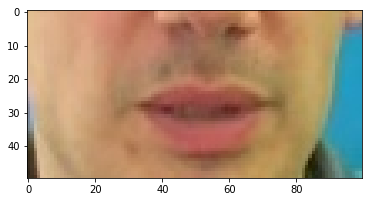

In [76]:
plt.imshow(out[20])

In [22]:
def load_image_from_path(path):
    out = np.zeros((75,50,100,3))
    for i in range(out.shape[0]):
        tmp_image = plt.imread(path+"/"+str(i)+".jpg")
        out[i] = tmp_image
    out/=255
    return out

# data path prepare

In [27]:
def prepare_data_path(peoples):
    for people in peoples:
        base_path = "./data_prepare/" + people + "/"
        all_path = []
        for path in os.listdir(base_path):
            all_path.append(base_path + path)
        return all_path

In [28]:
prepare_data_path(["s1"])

['./data_prepare/s1/bbaf2n']